<a href="https://colab.research.google.com/github/Wlnfadhil/Image-Classification-for-Cat-Dog-and-Tiger/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Image Classification Cat vs dog vs tiger
- **Nama:** wildan fadhil nazaruddin
- **Email:** wildanfadhil76@gmail.com
- **ID Dicoding:** @WildanFadhilNazaruddin

## Import Semua Packages/Library yang Digunakan

In [2]:
import zipfile
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage import io
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from PIL import Image

In [3]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [7]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [6]:
import os
import shutil

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### load images dataset

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle (5).json to kaggle (5).json


{'kaggle (5).json': b'{"username":"wlnfdhln","key":"c8c7bdd55161775aeb850cb3c38aca0a"}'}

In [12]:
# Mendonwload dari Kaggle
! kaggle datasets download nicopalv/dataset-klasifikasi-gambar-hewan

Dataset URL: https://www.kaggle.com/datasets/nicopalv/dataset-klasifikasi-gambar-hewan
License(s): unknown
 99% 434M/436M [00:23<00:00, 19.5MB/s]
100% 436M/436M [00:23<00:00, 19.6MB/s]


In [13]:
# Path ke dataset.zip Hasil Download dari Kaggle
zip_path = '/content/dataset-klasifikasi-gambar-hewan.zip'

# Path untuk ekstraksi
extract_path = '/content'

# Ekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the path to the dataset folder
dataset_path = os.path.join(extract_path, 'dataset')

# Listing the files in the dataset folder to ensure it's correctly extracted
print(os.listdir(dataset_path))

['test_set', 'training_set']


In [14]:
import os

# Path ke direktori dataset
dataset_path = "/content/dataset"

# Ekstensi gambar yang ingin dihitung
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff")

# Hitung jumlah file gambar
total_images = sum(
    len([f for f in files if f.lower().endswith(image_extensions)])
    for _, _, files in os.walk(dataset_path)
)

print(f"Total jumlah gambar: {total_images}")


Total jumlah gambar: 15000


In [15]:
!mkdir data

In [16]:
import os
import random
from PIL import Image

# Sumber direktori: train dan val untuk setiap kategori
source_dirs = {
    "cats": [
        "/content/dataset/test_set/cats",
        "/content/dataset/training_set/cats"
    ],
    "dogs": [
        "/content/dataset/test_set/dogs",
        "/content/dataset/training_set/dogs"
    ],
    "tigers": [
        "/content/dataset/test_set/tigers",
        "/content/dataset/training_set/tigers"
    ]
}

# Direktori tujuan
target_root_dir = "/content/data"

# Resolusi yang akan dipilih secara acak
res = [(100, 100), (400, 200), (150, 300)]

# Fungsi untuk mengubah resolusi gambar
def resize_images(source_dirs, target_dir, res):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop setiap sumber direktori
    for source_dir in source_dirs:
        if not os.path.exists(source_dir):  # Lewati jika tidak ada
            continue

        for root, _, files in os.walk(source_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        # Pilih resolusi secara acak
                        new_res = random.choice(res)
                        img_resized = img.resize(new_res)

                        # Simpan gambar yang telah diubah resolusinya
                        relative_path = os.path.relpath(root, source_dir)
                        target_path = os.path.join(target_dir, relative_path)

                        if not os.path.exists(target_path):
                            os.makedirs(target_path)

                        img_resized.save(os.path.join(target_path, file))

# Mengubah resolusi gambar untuk setiap kategori
for category, source_dirs_list in source_dirs.items():
    target_dir = os.path.join(target_root_dir, category)
    resize_images(source_dirs_list, target_dir, res)

print("Proses resize selesai!")


Proses resize selesai!


In [17]:
# Path ke direktori dataset
dataset_dir = '/content/data'

# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap folder (Boot, Sandal, Shoe)
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)

    if os.path.isdir(label_dir):
        # Iterasi melalui setiap gambar dalam folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ganti ekstensi jika perlu
                filepath = os.path.join(label_dir, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

In [18]:
import os

# Path ke direktori dataset
dataset_path = "/content/data"

# Ekstensi gambar yang ingin dihitung
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff")

# Hitung jumlah file gambar
total_images = sum(
    len([f for f in files if f.lower().endswith(image_extensions)])
    for _, _, files in os.walk(dataset_path)
)

print(f"Total jumlah gambar: {total_images}")

Total jumlah gambar: 15000


In [19]:
from PIL import Image
import pandas as pd

# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # Mengembalikan (width, height)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

# Asumsikan dataset_df sudah ada
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)

# Memisahkan width dan height menjadi dua kolom
dataset_df[['width', 'height']] = pd.DataFrame(dataset_df['resolution'].tolist(), index=dataset_df.index)

# Hapus kolom 'resolution' karena sudah dipisah
dataset_df.drop(columns=['resolution'], inplace=True)

# Menampilkan hasil
dataset_df.head()


,filename,filepath,label,width,height
0,cat.285.jpg,/content/data/cats/cat.285.jpg,cats,400,200
1,cat.4670.jpg,/content/data/cats/cat.4670.jpg,cats,150,300
2,cat.4486.jpg,/content/data/cats/cat.4486.jpg,cats,100,100
3,cat.4133.jpg,/content/data/cats/cat.4133.jpg,cats,150,300
4,cat.4046.jpg,/content/data/cats/cat.4046.jpg,cats,150,300


In [17]:
dataset_df

,filename,filepath,label,width,height
0,001139.jpg,/content/data/tigers/001139.jpg,tigers,100,100
1,001565.jpg,/content/data/tigers/001565.jpg,tigers,400,200
2,001249.jpg,/content/data/tigers/001249.jpg,tigers,150,300
3,004952.jpg,/content/data/tigers/004952.jpg,tigers,400,200
4,tiger.658.jpg,/content/data/tigers/tiger.658.jpg,tigers,400,200
...,...,...,...,...,...
14995,dog.1774.jpg,/content/data/dogs/dog.1774.jpg,dogs,400,200
14996,dog.2786.jpg,/content/data/dogs/dog.2786.jpg,dogs,400,200
14997,dog.553.jpg,/content/data/dogs/dog.553.jpg,dogs,400,200
14998,dog.872.jpg,/content/data/dogs/dog.872.jpg,dogs,400,200


In [18]:
dataset_df['label'].value_counts()

,count
label,
tigers,5000
cats,5000
dogs,5000


<Axes: >

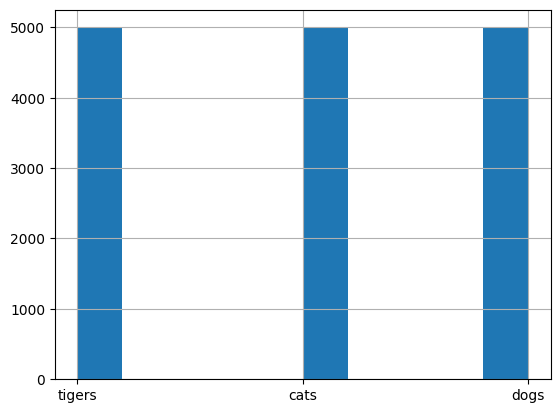

In [19]:
# membuat histogram untuk semua kategori pada class variable
dataset_df['label'].hist()

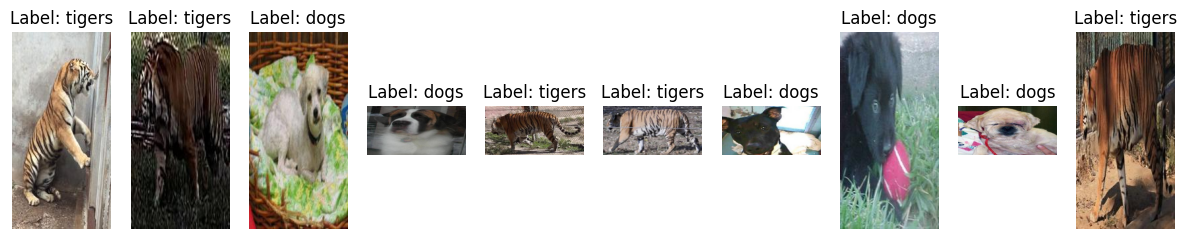

In [20]:
# Pilih hanya 9 gambar pertama (atau pilih subset lainnya jika diperlukan)
df_sample = dataset_df.sample(frac=1).reset_index(drop=True).head(10)

# Menampilkan gambar dan label
def display_images_with_labels(df):
    num_images = len(df)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]  # Jika hanya satu gambar, axes tidak dalam bentuk list

    for ax, (idx, row) in zip(axes, df.iterrows()):
        img = mpimg.imread(row['filepath'])
        ax.imshow(img)
        ax.set_title(f'Label: {row["label"]}')
        ax.axis('off')  # Menghilangkan axis

    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_images_with_labels(df_sample)

In [20]:
# menggunakan GPU untuk mengefisienkan waktu training model
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class CallbackModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

def hewan():
    TRAINING_DIR = "/content/data"

    # Augmentasi training
    training_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        rotation_range=30,
        brightness_range=[0.8, 1.2],
        validation_split=0.2
    )

    # Augmentasi validasi (hanya rescale)
    validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Load dataset
    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        batch_size=128,
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        batch_size=128,
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

    # Model CNN (Optimalisasi)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    # Callback (Stop training jika tidak meningkat)
    callback = [
        CallbackModel(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
    ]

    # Kompilasi model (Menggunakan AdamW agar lebih stabil)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4), metrics=['accuracy'])

    # Train model
    history = model.fit(
        train_generator,
        epochs=1000,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=callback,
        verbose=1
    )

    return model, history


In [22]:
model, history = hewan()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5496 - loss: 1.3140 - val_accuracy: 0.3347 - val_loss: 2.1859 - learning_rate: 0.0010
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 980ms/step - accuracy: 0.6816 - loss: 0.6656 - val_accuracy: 0.3343 - val_loss: 2.2035 - learning_rate: 0.0010
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 963ms/step - accuracy: 0.6958 - loss: 0.6050 - val_accuracy: 0.4780 - val_loss: 1.2546 - learning_rate: 0.0010
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 90s 962ms/step - accuracy: 0.7412 - loss: 0.5437 - val_accuracy: 0.5823 - val_loss: 0.9950 - learning_rate: 0.0010
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 968ms/step - accuracy: 0.7637 - loss: 0.4930 - val_accuracy: 0.6247 - val_loss: 0.8576 - learning_rate: 0.0010
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 981ms/step - accuracy: 0.7756 - loss: 0.4834 - val_accuracy: 0.6827 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 956ms/step - accuracy: 0.78

## Evaluasi dan Visualisasi

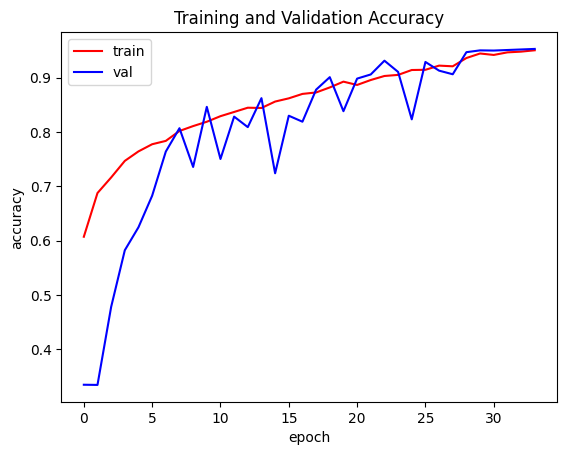

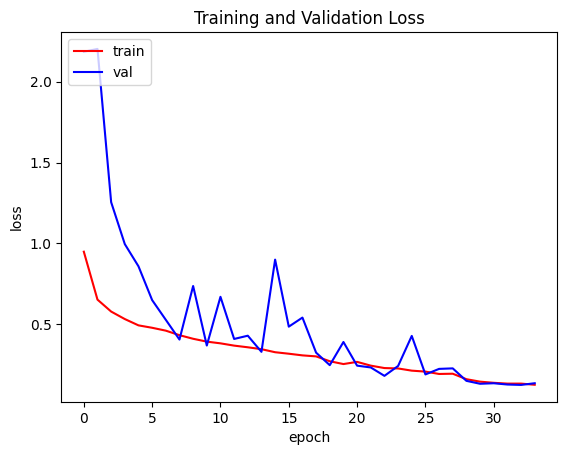

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

### save model

In [41]:
model.export('/content/saved_model')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137592730478416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730478608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730480528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730479184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730480144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730478800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730476880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730475920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730478224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137592730479376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1375927304

In [42]:
# Compress the folder
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

# Download the compressed file
files.download('/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tensorflow.js

In [32]:
! pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [37]:
# Convert the model to TensorFlow.js format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model

2025-02-17 15:54:29.961115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739807669.981211   22077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739807669.987428   22077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib

In [43]:
# Compress the folder
shutil.make_archive('/content/model', 'zip', '/content/model')

# Download the compressed file
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tensoflow lite

In [44]:
# Load the TensorFlow SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the converted model to a file
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [1]:
class_labels = ["cats", "dogs", "tigers"]

with open('/content/label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")